# Load Packages and Data

In [1]:
import pybaseball as pb
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
#import time
from scipy.stats import pearsonr
from matplotlib.patches import Ellipse
#from statsmodels.stats.weightstats import DescrStatsW

pb.cache.enable()
pd.set_option('display.max_columns', None)

In [2]:
data2yr_raw = pb.statcast('2023-03-29', '2024-10-01')
pitches23_24 = data2yr_raw[data2yr_raw['game_type'] == "R"]

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|█████████████████████████████████████████| 433/433 [01:23<00:00,  5.18it/s]


# Data Transformation

## Add columns to pitch level data

#### Calculate release point deviation

In [3]:
pitch_means = pitches23_24.groupby(['pitch_type', 'pitcher', 'game_pk'])[['release_pos_x', 'release_pos_z']].transform('mean')

# Add the means as new columns
pitches23_24['mean_release_pos_x_pitch'] = pitch_means['release_pos_x']
pitches23_24['mean_release_pos_z_pitch'] = pitch_means['release_pos_z']

# Deviation from midpoint
pitches23_24['release_pos_dev_pitch'] = np.sqrt(
    (pitches23_24['release_pos_x'] - pitches23_24['mean_release_pos_x_pitch'])**2 +
    (pitches23_24['release_pos_z'] - pitches23_24['mean_release_pos_z_pitch'])**2
)

/var/folders/_4/0s_qrg3d1899nbn77d0qkhg00000gp/T/ipykernel_58983/3849927813.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  pitches23_24['mean_release_pos_x_pitch'] = pitch_means['release_pos_x']
/var/folders/_4/0s_qrg3d1899nbn77d0qkhg00000gp/T/ipykernel_58983/3849927813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches23_24['mean_release_pos_x_pitch'] = pitch_means['release_pos_x']
/var/folders/_4/0s_qrg3d1899nbn77d0qkhg00000gp/T/ipykernel_58983/3849927813.py:5: PerformanceWarning: DataFrame is highly 

#### Example for release position deviation calculation

In [4]:
chris_sale_example = pitches23_24[(pitches23_24['pitcher'] == 519242) 
             & (pitches23_24['game_pk'] == 747070) 
             & (pitches23_24['pitch_type'] == 'CH')
            ][['player_name', 'pitch_type', 'game_date', 'release_pos_x', 'release_pos_z', 
               'mean_release_pos_x_pitch', 'mean_release_pos_z_pitch', 'release_pos_dev_pitch']]

chris_sale_example

,player_name,pitch_type,game_date,release_pos_x,release_pos_z,mean_release_pos_x_pitch,mean_release_pos_z_pitch,release_pos_dev_pitch
11,"Sale, Chris",CH,2024-09-14,3.0,4.85,3.026667,4.798889,0.057649
31,"Sale, Chris",CH,2024-09-14,3.03,4.79,3.026667,4.798889,0.009493
173,"Sale, Chris",CH,2024-09-14,3.13,4.74,3.026667,4.798889,0.118936
594,"Sale, Chris",CH,2024-09-14,2.95,4.83,3.026667,4.798889,0.082739
800,"Sale, Chris",CH,2024-09-14,3.04,4.77,3.026667,4.798889,0.031817
872,"Sale, Chris",CH,2024-09-14,2.98,4.89,3.026667,4.798889,0.102367
968,"Sale, Chris",CH,2024-09-14,3.02,4.83,3.026667,4.798889,0.031817
1369,"Sale, Chris",CH,2024-09-14,2.99,4.74,3.026667,4.798889,0.069371
2609,"Sale, Chris",CH,2024-09-14,3.1,4.75,3.026667,4.798889,0.088136


In [5]:
np.mean(chris_sale_example['release_pos_dev_pitch'])

0.06581395250442523

#### Add Result Columns

In [6]:
pitches23_24['swinging_strike'] = pitches23_24['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
pitches23_24['swing'] = pitches23_24['description'].isin(['swinging_strike', 'swinging_strike_blocked', 'hit_into_play', 'foul', 'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip'])
pitches23_24['in_zone'] = (
    (pitches23_24['plate_x'].abs() <= 0.83) &
    (pitches23_24['plate_z'] >= pitches23_24['sz_bot']) &
    (pitches23_24['plate_z'] <= pitches23_24['sz_top'])
)
pitches23_24['chase'] = pitches23_24['swing'] & ~pitches23_24['in_zone']
pitches23_24['strike'] = ~pitches23_24['description'].isin(['ball', 'blocked_ball', 'hit_by_pitch', 'pitchout'])

/var/folders/_4/0s_qrg3d1899nbn77d0qkhg00000gp/T/ipykernel_58983/2315885197.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  pitches23_24['swinging_strike'] = pitches23_24['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
/var/folders/_4/0s_qrg3d1899nbn77d0qkhg00000gp/T/ipykernel_58983/2315885197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches23_24['swinging_strike'] = pitches23_24['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
/var/folders/_4/0s_qrg3d1899nbn77d0q

## Create pitcher-pitch type-game level data (e.g. Garrett Crochet's cutter on 6/19/24)

In [7]:
pitcher_pitch_game_level = pitches23_24.groupby(['pitcher', 'game_pk', 'pitch_type']).agg(
    mean_release_pos_x=('release_pos_x', 'mean'),
    mean_release_pos_z=('release_pos_z', 'mean'),
    avg_release_pt_dev=('release_pos_dev_pitch', 'mean'),
    #std_release_pt_dev=('release_pos_dev_pitch', 'std'), # Can substitute this line as an alternative release point deviation measure
    num_pitches=('pitch_type', 'size'),
    num_pitch_types=('pitch_type', 'nunique'),
    ab_enders=('estimated_woba_using_speedangle', lambda x: x.notna().sum()),
    woba_value=('woba_value', 'sum'),
    woba_denom=('woba_denom', 'sum'),
    xwoba=('estimated_woba_using_speedangle', 'mean'),
    num_k=('events', lambda x: (x == 'strikeout').sum()),
    num_swing=('swing', 'sum'),
    num_barrels=('launch_speed_angle', lambda x: (x == 6).sum()),
    num_bbe=('description', lambda x: (x == 'hit_into_play').sum()),
    sw_str_rt=('swinging_strike', 'mean'),
    chase_rt=('chase', 'mean'),
    zone_rt=('in_zone', 'mean'),
    strike_rt=('strike', 'mean')
).reset_index()


pitcher_pitch_game_level['whiff_rt'] = pitcher_pitch_game_level['sw_str_rt'] * pitcher_pitch_game_level['num_pitches'] / pitcher_pitch_game_level['num_swing']
pitcher_pitch_game_level['barrel_rt'] = pitcher_pitch_game_level['num_barrels']/pitcher_pitch_game_level['num_bbe']
pitcher_pitch_game_level['woba'] = pitcher_pitch_game_level['woba_value']/pitcher_pitch_game_level['woba_denom']
pitcher_pitch_game_level['wobacon'] = pitcher_pitch_game_level['woba_value']/(pitcher_pitch_game_level['woba_denom'] - pitcher_pitch_game_level['num_k'])
pitcher_pitch_game_level['xwobacon'] = pitcher_pitch_game_level['xwoba'] * (pitcher_pitch_game_level['ab_enders']) / (pitcher_pitch_game_level['ab_enders'] - pitcher_pitch_game_level['num_k'])

# Identify optimal hyperparameters

#### Correlation Confidence Interval Function

In [8]:
def correlation_confidence_interval(x, y):
    """
    Calculates correlation between two variables and its 95% confidence interval
    Arguments:
    x        - One column to calculate the correlation with
    y        - The other column to calculate the correlation with
    
    Returns:
    r        - Pearson's correlation (float)
    r_lower  - The lower bound of the 95% confidence interval for the correlation (float)
    r_upper  - The upper bound of the 95% confidence interval for the correlation (float)
    """
    
    # Steps to ensure we eliminate everything the pearsonr function cannot handle
    x = x.astype(float).to_numpy()
    y = y.astype(float).to_numpy()
    
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

    x = x[mask]
    y = y[mask]
       
    r, _ = pearsonr(x, y)
    n = len(x)
    if n <= 3:     # Can't compute CI with n <= 3
        return r, np.nan, np.nan  
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    
    return r, r_lower, r_upper

#### Custom correlation display

In [9]:
def pitch_corr(df, pitch_type, min_pitches):
    """
    Calculate and display correlation of average release point deviation and outcome metrics for the given
    pitch type and minimum pitch count (in a game)
    
    Arguments:
    df           - Pandas DataFrame aggregated to the pitcher-pitch-game level
    
    pitch_type   - Pitch type to view the correlations for. Use the key below.
                   Changeup        = 'CH'
                   Curveball       = 'CU'
                   Cutter          = 'FC'
                   4-Seam Fastball = 'FF'
                   Splitter        = 'FS'
                   Knuckle Curve   = 'KC'
                   Sinker          = 'SI'
                   Slider          = 'SL'
                   Sweeper         = 'ST'
                   
    min_pitches  - Minimum number of pitches to be included in the correlation (int)
    
    
    Returns:
    None         - Plots a heatmap of the correlation between average release point deviation and the outcome 
                   metrics as well as the number of pitchers and games included in the correlation
    """
    # Filter DataFrame
    df_pitch = df[(df['pitch_type'] == pitch_type) & (df['num_pitches'] >= min_pitches)]
    
    cols = ['avg_release_pt_dev', 'strike_rt', 'zone_rt', 'chase_rt', 'sw_str_rt', 
            'whiff_rt', 'barrel_rt', 'woba', 'xwoba', 'wobacon', 'xwobacon']
    outcome_labels = ['Strike Rate', 'Zone Rate', 'Chase Rate', 'Swinging Strike Rate',
                      'Whiff Rate', 'Barrel Rate', 'wOBA', 'xwOBA', 'wOBAcon', 'xwOBAcon']
    
    df_limit = df_pitch[cols]

    # Initialize correlation and annotation matrices
    corr_matrix = pd.DataFrame(index=cols[1:], columns=cols[:1])
    annot_matrix = pd.DataFrame(index=cols[1:], columns=cols[:1])
    
    target_col = 'avg_release_pt_dev'
    metrics = cols[1:]  # All outcome metrics
    
    # Iterate through each outcome metric
    for outcome in metrics:

        # Filter DataFrame
        valid_df = df_limit.copy()[[outcome, target_col]].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Must have at least 3 observations to calculate correlation
        if len(valid_df) > 3:
            r, r_lo, r_hi = correlation_confidence_interval(valid_df[target_col], valid_df[outcome])
            
            corr_matrix.loc[outcome, target_col] = r
            annot_matrix.loc[outcome, target_col] = f"{r:.2f}\n[{r_lo:.2f}, {r_hi:.2f}]"

        else:
            corr_matrix.loc[outcome, target_col] = np.nan
            annot_matrix.loc[outcome, target_col] = ""

    
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    plot = sns.heatmap(
        corr_matrix.astype(float),
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        linewidths=0.5,
        vmin=-0.2,
        vmax=0.2,
        center=0,
        cbar_kws={'label': 'Correlation'}
    )

    # Move x-axis labels to the top
    plot.xaxis.set_ticks_position('top')
    plot.xaxis.set_label_position('top')
        
    # Add axes labels
    plt.xticks([0.5], ['Average Release Point Deviation'], rotation=0)
    plt.yticks(np.array(range(0,10,1)) + 0.5, outcome_labels, rotation=0)

    plt.tight_layout()
    plt.show()
    
    print(f"Unique Pitchers Included: {df_pitch['pitcher'].nunique()}    Total Games Included: {len(df_pitch)}")

    return

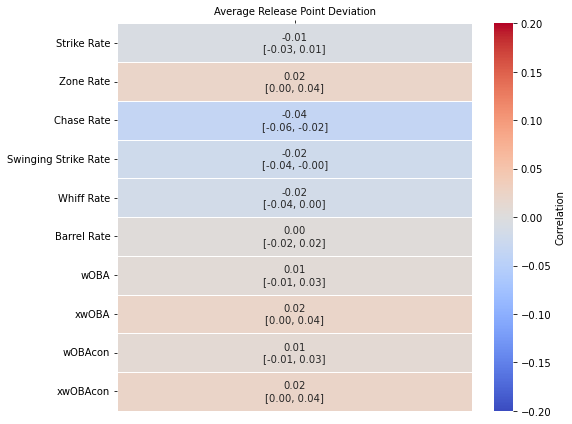

Unique Pitchers Included: 611    Total Games Included: 9998


In [10]:
pitch_corr(pitcher_pitch_game_level, 'CH', 5)

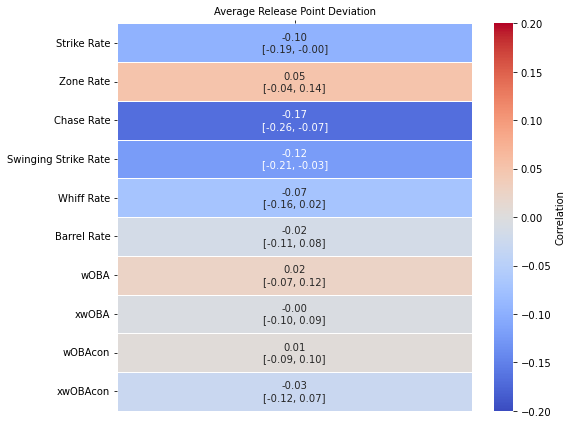

Unique Pitchers Included: 89    Total Games Included: 432


In [11]:
pitch_corr(pitcher_pitch_game_level, 'CH', 30)

#### Calculate number of statistically significant correlations function

In [12]:
def num_corr(df, pitch_type, min_pitches):
    """
    Calculates the number of statistically significant correlations between average release point deviation and 
    outcome metrics for a given pitch type and minimum pitch count per game

    Arguments:
    df           - Pandas DataFrame aggregated to pitcher-pitch type-game level
    
    pitch_type   - Pitch type to analyze. Use the key below.
                   Changeup        = 'CH'
                   Curveball       = 'CU'
                   Cutter          = 'FC'
                   4-Seam Fastball = 'FF'
                   Splitter        = 'FS'
                   Knuckle Curve   = 'KC'
                   Sinker          = 'SI'
                   Slider          = 'SL'
                   Sweeper         = 'ST'
                   
    min_pitches  - Minimum number of pitches thrown to be included (int)


    Returns:
    sig_count    - Number of outcome metrics statistically significantly correlated (alpha = 0.05) with 
                   average release point deviation
    """
    # Define columns
    cols = ['avg_release_pt_dev', 'strike_rt', 'zone_rt', 'chase_rt',
            'sw_str_rt', 'whiff_rt', 'barrel_rt', 'woba', 'xwoba', 'wobacon', 'xwobacon']

    # Filter and clean data
    df_pitch = df[(df['pitch_type'] == pitch_type) & (df['num_pitches'] >= min_pitches)]
    df_limit = df_pitch[cols].replace([np.inf, -np.inf], np.nan).dropna()

    sig_count = 0
    for outcome_metric in cols[1:]:
        valid_df = df_limit[['avg_release_pt_dev', outcome_metric]]
        if len(valid_df) > 3:
            r, r_lo, r_hi = correlation_confidence_interval(valid_df['avg_release_pt_dev'], valid_df[outcome_metric])
            
            if r_lo > 0 or r_hi < 0:
                sig_count += 1

    return sig_count

#### Identify the number of statistically significant correlations for each pitch type and minimum pitches

In [13]:
pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST']

results = {}

for pitch in pitch_types:
    results[pitch] = {}
    
    for num in range(5, 31, 5):
        val = num_corr(pitcher_pitch_game_level, pitch_type = pitch, min_pitches = num)
        results[pitch][num] = val
        
print(pd.DataFrame(results))

    CH  CU  FC  FF  FS  KC  SI  SL  ST
5    1   1   0   5   1   0   7   4   3
10   2   3   0   2   2   0   4   4   3
15   3   5   2   2   3   1   5   2   1
20   3   8   0   2   4   1   5   2   0
25   3   6   0   3   2   1   1   2   2
30   3   7   1   3   2   0   0   2   3


# Correlations

#### Display all correlations function

In [14]:
def pitch_corr_all(df):
    """
    Calculates and displays the correlation and confidence interval for each pitch type and outcome metric 
    combination given the optimized hyperparameters
    
    Arguments:
    df    - Pandas DataFrame aggregated to pitcher-pitch type-game level
    
    Returns:
    None  - Prints heatmap of all correlations with statistically significant ones circled
    """
    
    # Optimal minimum pitches as defined above
    pitch_types = {'CH':20, 'CU':20, 'FC':15, 'FF':5, 'FS':20, 'KC':20, 'SI':5, 'SL':10, 'ST':5}
    pitch_labels = ['Changeup', 'Curveball', 'Cutter', '4-Seam Fastball', 'Splitter', 
                    'Knuckle Curve', 'Sinker', 'Slider', 'Sweeper']
    
    # Outcome metrics
    cols = ['strike_rt', 'zone_rt', 'chase_rt', 'sw_str_rt', 'whiff_rt', 
            'barrel_rt', 'woba', 'xwoba', 'wobacon', 'xwobacon']
    outcome_labels = ['Strike Rate', 'Zone Rate', 'Chase Rate', 'Swinging Strike Rate',
                      'Whiff Rate', 'Barrel Rate', 'wOBA', 'xwOBA', 'wOBAcon', 'xwOBAcon']
    
    target_col = 'avg_release_pt_dev'
    metrics = cols[:]  # All outcome metrics

    # Initialize combined DataFrames
    corr_matrix_all = pd.DataFrame(index=metrics)
    annot_matrix_all = pd.DataFrame(index=metrics)
    annot_matrix_round_all = pd.DataFrame(index=metrics)

    
    # Iterate through each pitch type
    for pitch_type, min_pitches in pitch_types.items():
        
        # Filter DataFrame
        df_pitch = df[(df['pitch_type'] == pitch_type) & (df['num_pitches'] >= min_pitches)]

        temp_corrs = []
        temp_annots = []
        temp_annots_round = []
        
        # Iterate through each outcome metric
        for metric in metrics:
            
            # Filter DataFrame
            valid_df = df_pitch[[target_col, metric]].dropna()
            
            # Must have at least 3 observations to calculate correlation
            if len(valid_df) > 3:
                r, r_lo, r_hi = correlation_confidence_interval(valid_df[target_col], valid_df[metric])
                temp_corrs.append(r)
                temp_annots.append(f"{r}\n[{r_lo}, {r_hi}]")
                temp_annots_round.append(f"{r:.2f}\n[{r_lo:.2f}, {r_hi:.2f}]")
                
                
            else:
                temp_corrs.append(np.nan)
                temp_annots.append("")
                temp_annots_round.append("")
        
        
        corr_matrix_all[pitch_type] = temp_corrs
        annot_matrix_all[pitch_type] = temp_annots
        annot_matrix_round_all[pitch_type] = temp_annots_round


    # Plot all pitch types together
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(
        corr_matrix_all.astype(float),
        annot=annot_matrix_round_all,
        fmt='',
        cmap='coolwarm',
        linewidths=0.5,
        vmin=-0.2,
        vmax=0.2,
        center=0,
        cbar_kws={'label': 'Correlation'}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    plt.title("Correlation of Average Release Point Deviation with Outcome Metrics")
    plt.xticks(np.array(range(0,9,1)) + 0.5, pitch_labels, rotation=0)
    plt.yticks(np.array(range(0,10,1)) + 0.5, outcome_labels, rotation=0)


    # Overlay red ovals for significant correlations
    for y_idx, metric in enumerate(corr_matrix_all.index):
        for x_idx, pitch_type in enumerate(corr_matrix_all.columns):
            annot = annot_matrix_all.loc[metric, pitch_type]
            if annot and '\n[' in annot:
                try:
                    r_ci = annot.split('\n[')[-1].strip(']')
                    r_lo, r_hi = map(float, r_ci.split(', '))
                        
                    if r_lo > 0 or r_hi < 0:
                        ellipse = Ellipse(
                            (x_idx + 0.5, y_idx + 0.55),  # Center of the cell
                            width=0.85, height=0.8,       # Oval dimensions
                            edgecolor='red',
                            facecolor='none',
                            linewidth=4
                        )
                        ax.add_patch(ellipse)
                except:
                    pass

    plt.tight_layout()
    plt.show()

    return

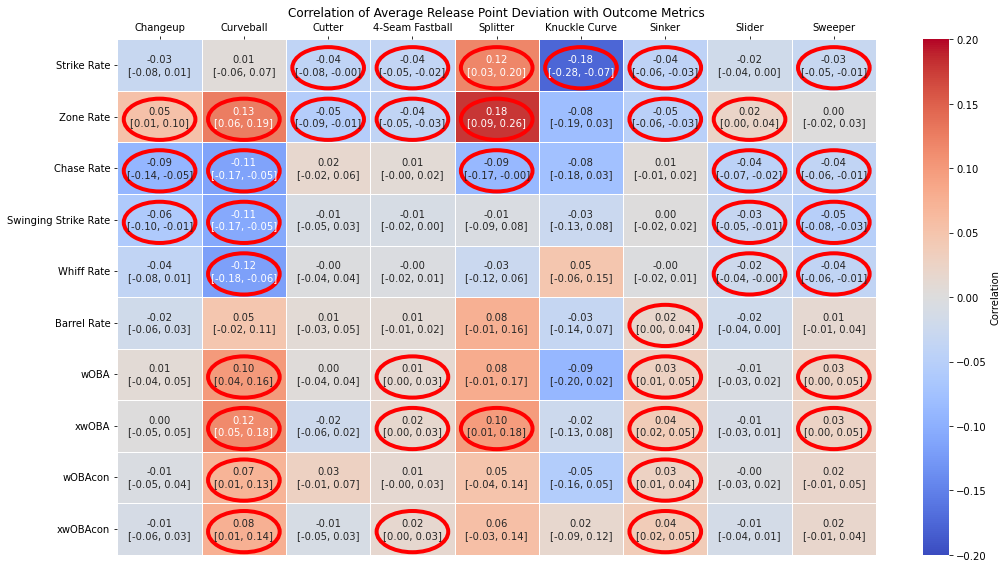

In [15]:
pitch_corr_all(pitcher_pitch_game_level)

# Pitch Location Analysis

#### Create dataframe with average release point deviation aggregated at the pitcher-pitch type level (weighted by number of pitches across all games)

In [16]:
pitcher_pitch_avg_dev = (
    pitcher_pitch_game_level
    .groupby(['pitcher', 'pitch_type'])
    .apply(lambda g: pd.Series({
        'wt_avg_release_pt_dev': (g['avg_release_pt_dev'] * g['num_pitches']).sum() / g['num_pitches'].sum(),
        'total_pitches': g['num_pitches'].sum()
    }))
    .reset_index()
)

#### Matt Strahm example

In [17]:
pitcher_pitch_avg_dev[pitcher_pitch_avg_dev['pitcher'] == 621381]

,pitcher,pitch_type,wt_avg_release_pt_dev,total_pitches
1471,621381,CH,0.059258,7.0
1472,621381,FC,0.139001,243.0
1473,621381,FF,0.365719,1140.0
1474,621381,SI,0.500495,407.0
1475,621381,SL,0.577379,550.0


#### Create key to map MLBAM IDs to FanGraphs IDs

Note: In theory, the code below creates a key automatically, but in practice there are many pitchers in this dataset who are missing FanGraphs IDs. This may be resolved in the future, but I downloaded a complete key (see GitHub) to use presently

In [18]:
"""
pitchers = pitcher_pitch_game_level['pitcher'].unique()
pitcher_key = pb.playerid_reverse_lookup(pitchers, key_type='mlbam')
pitcher_key = pitcher_key[['key_mlbam', 'key_fangraphs']]
"""

"\npitchers = pitcher_pitch_game_level['pitcher'].unique()\npitcher_key = pb.playerid_reverse_lookup(pitchers, key_type='mlbam')\npitcher_key = pitcher_key[['key_mlbam', 'key_fangraphs']]\n"

Use pitcher key provided in Github

In [19]:
path = 'your_path_here'
download_pitcher_key = pd.read_csv(path + '/fangraphs_pitchers_key.csv')
download_pitcher_key = download_pitcher_key[['PlayerId', 'MLBAMID']]

#### Download PitchingBot and Pitching+ stats from FanGraphs

In [20]:
fg_stats = pb.pitching_stats(start_season = 2023, end_season = 2024, split_seasons = False, qual = 0)

prefixes = ('bot', 'Stf', 'Loc', 'Pit')
desired_cols = ['IDfg', 'Name'] + [col for col in fg_stats.columns if col.startswith(prefixes)]

fg_filtered = fg_stats[desired_cols]

#### Format PitchingBot and Pitching+ metrics

In [21]:
fg_melted = fg_filtered.melt(id_vars=['IDfg', 'Name'], var_name='stat_type', value_name='value')
fg_melted['pitch_type'] = fg_melted['stat_type'].str.extract(r'([A-Z]{2})$')
fg_melted['stat'] = fg_melted['stat_type'].str.extract(r'^(.*) [A-Z]{2}$')
fg_pivoted = (
    fg_melted
    .pivot_table(index=['IDfg', 'Name', 'pitch_type'], columns='stat', values='value')
    .reset_index()
)
fg_pivoted['pitch_type'] = fg_pivoted['pitch_type'].replace({'FA': 'FF'})

#### Edward Cabrera data example

In [22]:
fg_pivoted[fg_pivoted['IDfg'] == 21690]

stat,IDfg,Name,pitch_type,Loc+,Pit+,Stf+,botCmd,botOvr,botStf
2978,21690,Edward Cabrera,CH,102.0,106.0,97.0,53.0,51.0,57.0
2979,21690,Edward Cabrera,CU,98.0,104.0,109.0,56.0,58.0,60.0
2980,21690,Edward Cabrera,FF,90.0,83.0,93.0,40.0,42.0,51.0
2981,21690,Edward Cabrera,SI,91.0,103.0,104.0,34.0,44.0,61.0
2982,21690,Edward Cabrera,SL,96.0,101.0,107.0,46.0,42.0,49.0


#### Join all the data together to create a dataframe aggregated on the pitcher-pitch type level (e.g. Garrett Crochet's cutter)

In [23]:
pitcher_pitch_full = pitcher_pitch_avg_dev.merge(
    download_pitcher_key, 
    how='left', 
    left_on='pitcher', 
    right_on='MLBAMID').merge(
    fg_pivoted, 
    how='left', 
    left_on=['PlayerId', 'pitch_type'], 
    right_on=['IDfg', 'pitch_type']).drop(['PlayerId', 'MLBAMID'], axis=1)

#### Function to calculate and display correlations and confidence intervals for average release point deviation and location metrics

In [24]:
def pitch_corr_loc(df, min_pitches):
    """
    Calculates and displays the correlation and confidence interval for each pitch type and location metric 
    combination
    
    Arguments:
    df           - Pandas DataFrame aggregated to pitcher-pitch level
    min_pitches  - minimum number of pitches in 2023-24 to be included (int)
    
    Returns:
    None         - prints heatmap of all correlations with statistically significant ones circles
    """
    
    # Filter DataFrame
    df = df[df['total_pitches'] >= min_pitches]
    cols = ['Loc+', 'botCmd']
    
    # Only these pitch types have model scores (no sweeper)
    pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL']
    pitch_labels = ['Changeup', 'Curveball', 'Cutter', '4-Seam Fastball', 
                    'Splitter', 'Knuckle Curve', 'Sinker', 'Slider']
    
    target_col = 'wt_avg_release_pt_dev'
    metrics = cols[:]  # All outcome metrics

    # Initialize combined DataFrames
    corr_matrix_all = pd.DataFrame(index=metrics)
    annot_matrix_all = pd.DataFrame(index=metrics)
    annot_matrix_round_all = pd.DataFrame(index=metrics)
    
    # Iterate through all pitch types
    for pitch_type in pitch_types:
        
        df_pitch = df[df['pitch_type'] == pitch_type]
        df_limit = df_pitch[[target_col] + metrics].replace([np.inf, -np.inf], np.nan).dropna()

        temp_corrs = []
        temp_annots = []
        temp_annots_round = []
        
        # Iterate through all location matrics
        for metric in metrics:
            valid_df = df_limit[[target_col, metric]].dropna()
            
            # Need at least 3 observations to calculate correlation
            if len(valid_df) > 3:
                r, r_lo, r_hi = correlation_confidence_interval(valid_df[target_col], valid_df[metric])
                temp_corrs.append(r)
                temp_annots.append(f"{r}\n[{r_lo}, {r_hi}]")
                temp_annots_round.append(f"{r:.2f}\n[{r_lo:.2f}, {r_hi:.2f}]")
            else:
                temp_corrs.append(np.nan)
                temp_annots.append("")
                temp_annots_round.append("")
        
        
        corr_matrix_all[pitch_type] = temp_corrs
        annot_matrix_all[pitch_type] = temp_annots
        annot_matrix_round_all[pitch_type] = temp_annots_round


    # Plot all pitch types together
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(
        corr_matrix_all.astype(float),
        annot=annot_matrix_round_all,
        fmt='',
        cmap='coolwarm',
        linewidths=0.5,
        vmin=-0.3,  # Minimum value for correlation shading
        vmax=0.3,   # Maximum value for correlation shading
        center=0,   # Center value for correlation shading
        cbar_kws={'label': 'Correlation'}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    plt.title("Correlation of Release Point Deviation with Location Metrics")
    plt.xticks(np.array(range(0,8,1)) + 0.5, pitch_labels, rotation=0)

    # Overlay red ovals for significant correlations
    for y_idx, metric in enumerate(corr_matrix_all.index):
        for x_idx, pitch_type in enumerate(corr_matrix_all.columns):
            annot = annot_matrix_all.loc[metric, pitch_type]
            if annot and '\n[' in annot:
                try:
                    r_ci = annot.split('\n[')[-1].strip(']')
                    r_lo, r_hi = map(float, r_ci.split(', '))
                    if r_lo > 0 or r_hi < 0:
                        ellipse = Ellipse(
                            (x_idx + 0.5, y_idx + 0.55),  # Center of the cell
                            width=0.85, height=0.8,       # Oval dimensions
                            edgecolor='red',
                            facecolor='none',
                            linewidth=4
                        )
                        ax.add_patch(ellipse)
                except:
                    pass

    plt.tight_layout()
    plt.show()


    return

#### Location correlation with minimum 50 pitches

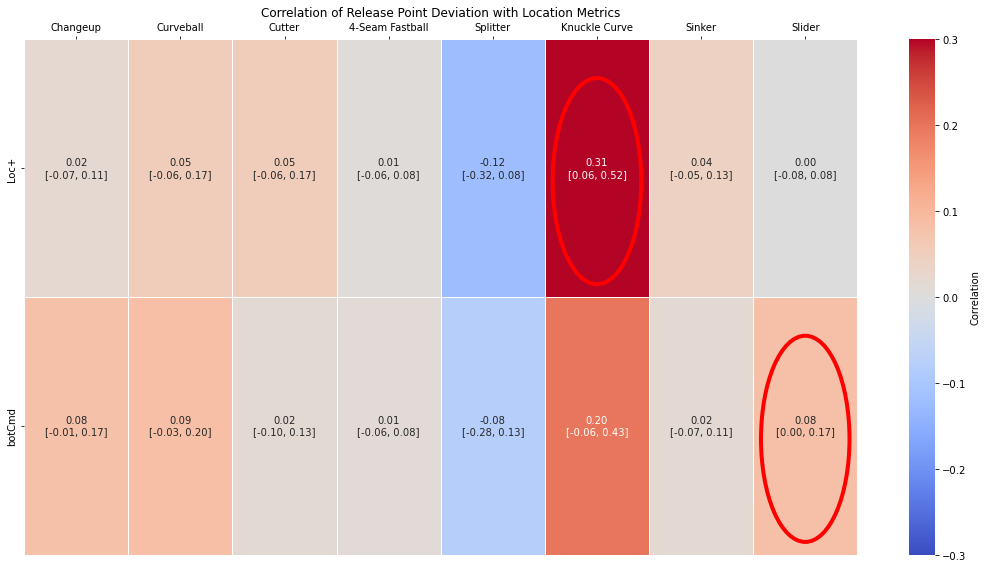

In [25]:
pitch_corr_loc(pitcher_pitch_full, 50)

#### Location correlations with minimum 400 pitches

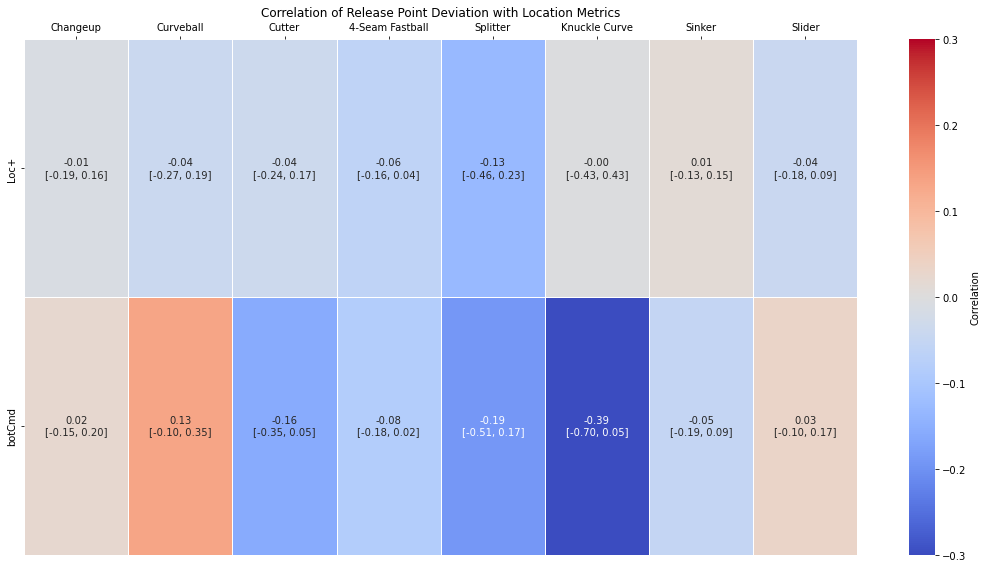

In [26]:
pitch_corr_loc(pitcher_pitch_full, 400)

#### Display how many pitchers qualify for the above correlations

In [27]:
pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL']

pitcher_pitch_full[(pitcher_pitch_full['total_pitches'] > 400) &
                  (pitcher_pitch_full['pitch_type'].isin(pitch_types))].groupby('pitch_type').size()

pitch_type
CH    126
CU     71
FC     94
FF    374
FS     33
KC     23
SI    200
SL    210
dtype: int64

#### Function to generate weighted percentiles to account for sample size

In [28]:
def weighted_percentile_rank_grouped(df, group_col, value_col, weight_col, percentile_col_name='percentile'):
    """
    Computes weighted percentile rank and adds this as a column to df. Intended to get percentile by weighted 
    average release point deviation (wt_avg_release_pt_dev) by pitch type and weighted by total_pitches
    
    Arguments:
    df                   - pandas DataFrame with columns to group, weigh, and calculate the percentile on
    group_col            - column name to group the data in; percentiles will be calculated within the group
                           (string)
    value_col            - column name of the variable to calculate the percentiles for (string)
    weight_col           - column name of the weight variable (string)
    percentile_col_name  - column name for the new percentile column (string)
    
    Returns:
    pandas DataFrame with the new percentile column
    """
    
    # Helper Function
    def compute_percentile(group):
        group = group.sort_values(value_col).reset_index(drop=True)
        cumsum = group[weight_col].cumsum()
        total = group[weight_col].sum()
        group[percentile_col_name] = cumsum / total
        return group

    return df.groupby(group_col, group_keys=False).apply(compute_percentile)


#### Add aggregated stats back to individual pitch level data to enable plotting

In [29]:
pitches_w_stats = pitches23_24.merge(pitcher_pitch_full, how='left', on=['pitcher', 'pitch_type'])
pitches_w_stats = pitches_w_stats[['pitch_type', 'pitcher', 'p_throws','total_pitches', 'release_pos_x', 
                                   'release_pos_z', 'plate_x', 'plate_z', 'Loc+', 'botCmd', 
                                   'wt_avg_release_pt_dev']]

In [30]:
def pitch_density_plot(pitches_df, pitch_type='FF', percentile=0.1, pitcher_hand = 'Both', min_pitches = 0, weighted = False, bw_adjust=1):
    """
    Plot side-by-side density plots of pitch locations (plate_x vs plate_z) for a given pitch type,
    showing the pitchers with the most and least consistent release points for that pitch

    Arguments:
    pitches_df    - Pandas DataFrame aggregated on an individual pitch level
                    
    pitch_type    - Pitch type to filter. Use the key below.
                    Changeup        = 'CH'
                    Curveball       = 'CU'
                    Cutter          = 'FC'
                    4-Seam Fastball = 'FF'
                    Splitter        = 'FS'
                    Knuckle Curve   = 'KC'
                    Sinker          = 'SI'
                    Slider          = 'SL'
                    Sweeper         = 'ST'
                   
    percentile    - Threshold (0 to 1) for top/bottom percentiles (float)
    
    pitcher_hand  - Specify which handedness of pitcher to consider: 
                    'Right'  = right handed only
                    'Left'   = left handed only 
                    'Both'   = all pitchers
                    'Mirror' = left handed pitches are mirrored on the x-axis to match glove-side/arm-side 
                               with right handed pitchers
                    
    min_pitcher   - Minimum number of pitches to be included (int)
    
    weighted      - Indicator for whether to calculated weighted percentiles. True gives proportionally 
                    increased weight to pitchers with more pitches when calculating percentiles (boolean)
                    
    bw_adjust     - Bandwidth adjustment for kde smoothing (float)
    
    
    Returns:
    None          -  Plots side-by-side density plots
    """
    
    # Filter DataFrame
    df_filtered = pitches_df[(pitches_df['pitch_type'] == pitch_type) 
                             & (pitches_df['total_pitches'] >= min_pitches)].copy()
    
    # Check for errors
    if pitcher_hand not in ['Right', 'Left', 'Both', 'Mirror']:
        return ('Error: Please specify pitcher handedness')
    
    
    if pitcher_hand == 'Right':
        df_filtered = df_filtered[df_filtered['p_throws']=='R']
    
    if pitcher_hand == 'Left':
        df_filtered = df_filtered[df_filtered['p_throws']=='L']
        
    if pitcher_hand == 'Mirror':
        df_filtered.loc[df_filtered['p_throws'] == 'L', 'plate_x'] *= -1

        
    # Label percentile groups
    if weighted == True:
        # Call function to calculate weighted percentiles
        df_filtered = weighted_percentile_rank_grouped(
            df_filtered,
            group_col='pitch_type',
            value_col='wt_avg_release_pt_dev',
            weight_col='total_pitches',
            percentile_col_name='percentile'
        )
        
    else:
        # Calculate unweighted percentiles
        df_filtered['percentile'] = (
            df_filtered
            .groupby('pitch_type')['wt_avg_release_pt_dev']
            .rank(pct=True)
        )
    
    # Define top and bottom groups
    df_filtered['percentile_group'] = np.where(
        df_filtered['percentile'] >= (1 - percentile), f'{int(percentile*100)}% most deviation',
        np.where(df_filtered['percentile'] <= percentile, f'{int(percentile*100)}% least deviation', np.nan)
    )

    # Keep only the top and bottom groups
    df_filtered = df_filtered.dropna(subset=['percentile_group'])

    # Split groups
    inconsistent_group = df_filtered[df_filtered['percentile_group'].str.contains('most')]
    consistent_group = df_filtered[df_filtered['percentile_group'].str.contains('least')]

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14,9), sharex=True, sharey=True)

    for ax, data, title in zip(axes, [inconsistent_group, consistent_group], ['Least Consistent Release', 'Most Consistent Release']):
        sns.kdeplot(
            data=data,
            x='plate_x',
            y='plate_z',
            fill=True,
            cmap='viridis',
            thresh=0.05,
            levels=100,
            alpha=0.7,
            bw_adjust=bw_adjust,
            ax=ax
        )

        # Strike zone
        ax.axhline(1.5, color='black', linestyle='--')
        ax.axhline(3.5, color='black', linestyle='--')
        ax.axvline(-0.85, color='black', linestyle='--')
        ax.axvline(0.85, color='black', linestyle='--')
        
        pitch_type_key = {'CH':'Changeup', 'CU':'Curveball', 'FC':'Cutter', 'FF':'4-Seam Fastball', 
                          'FS':'Splitter', 'KC':'Knuckle Curve', 'SI':'Sinker', 'SL':'Slider'}

        ax.set_title(f'{pitch_type_key[pitch_type]} Location Density: {int(percentile*100)}% {title}')
        ax.set_xlabel('Plate X')
        ax.set_ylabel('Plate Z')
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(0, 5)
        ax.grid(True) 

    plt.tight_layout()
    plt.show()
    
    return

### Pitch density plots for each pitch type

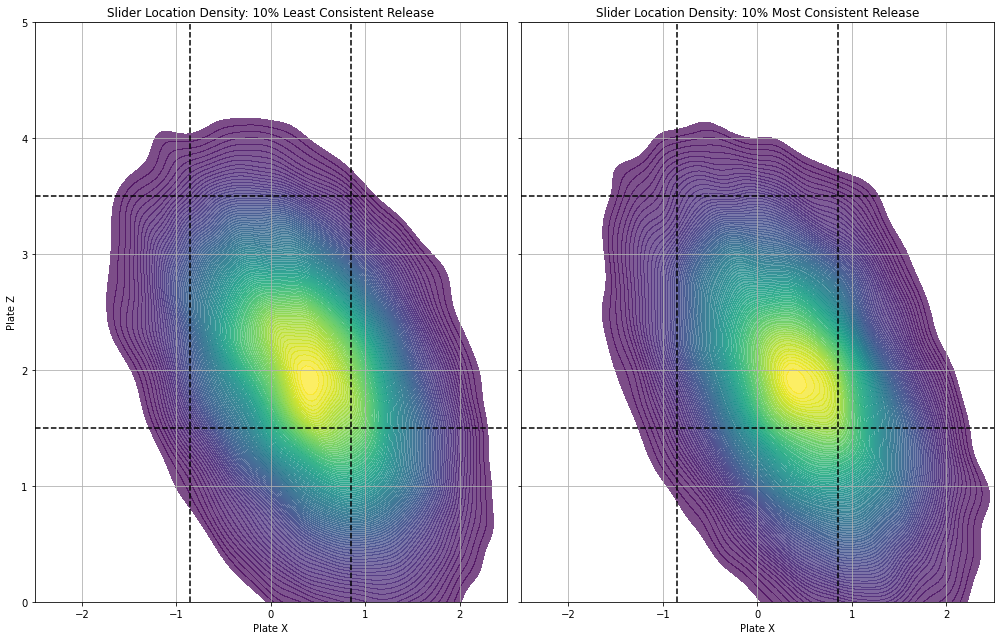

In [31]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='SL',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

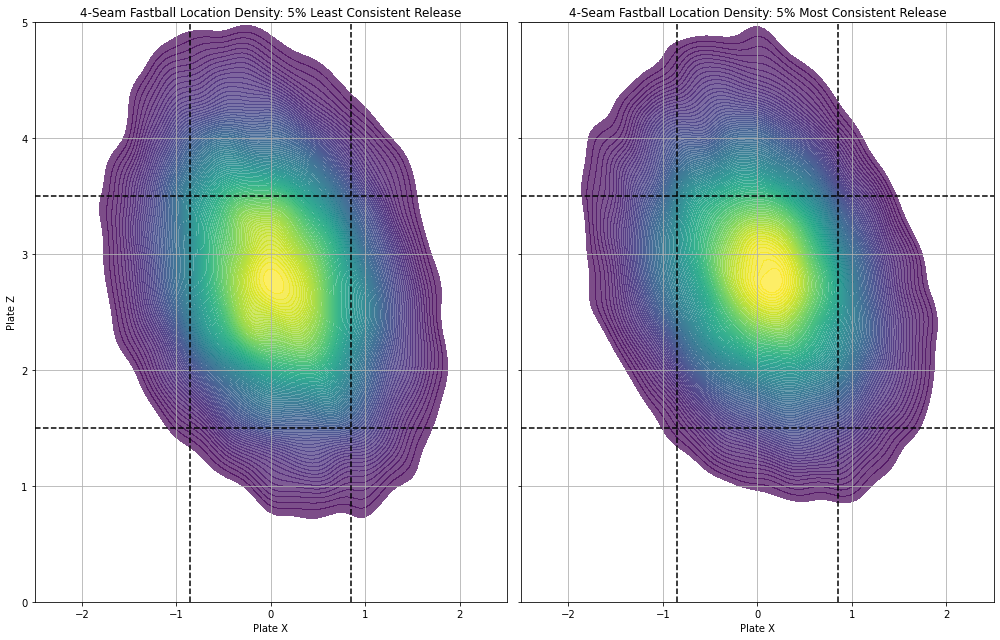

In [32]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='FF',
    percentile=0.05, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

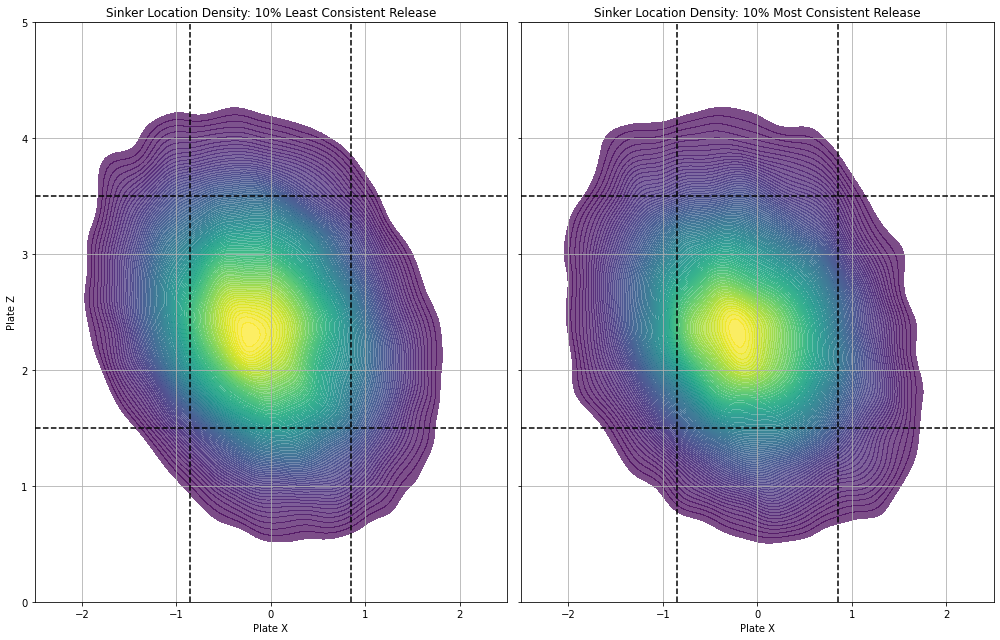

In [33]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='SI',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

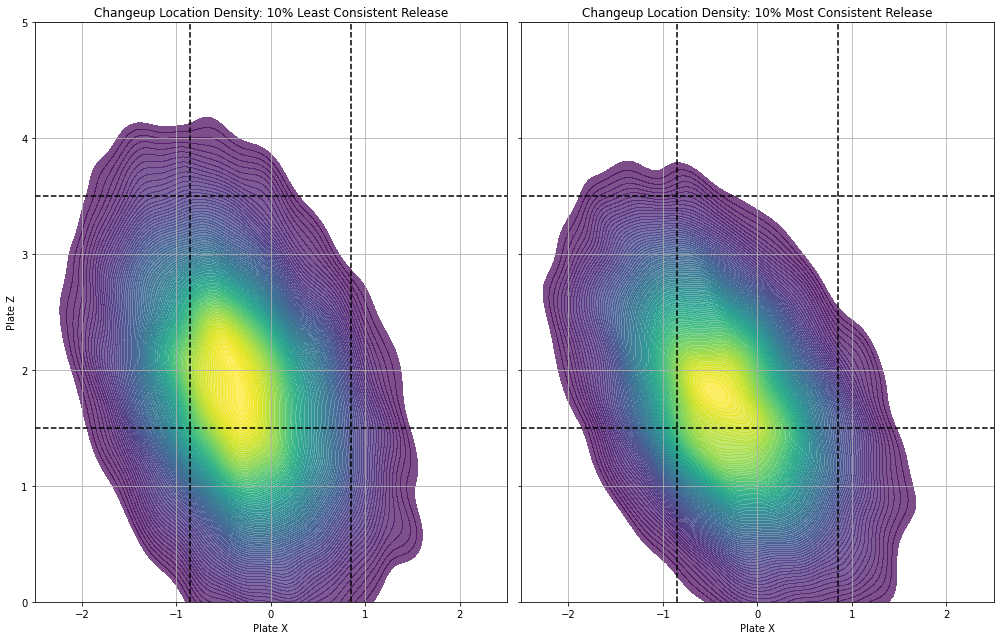

In [34]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='CH',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

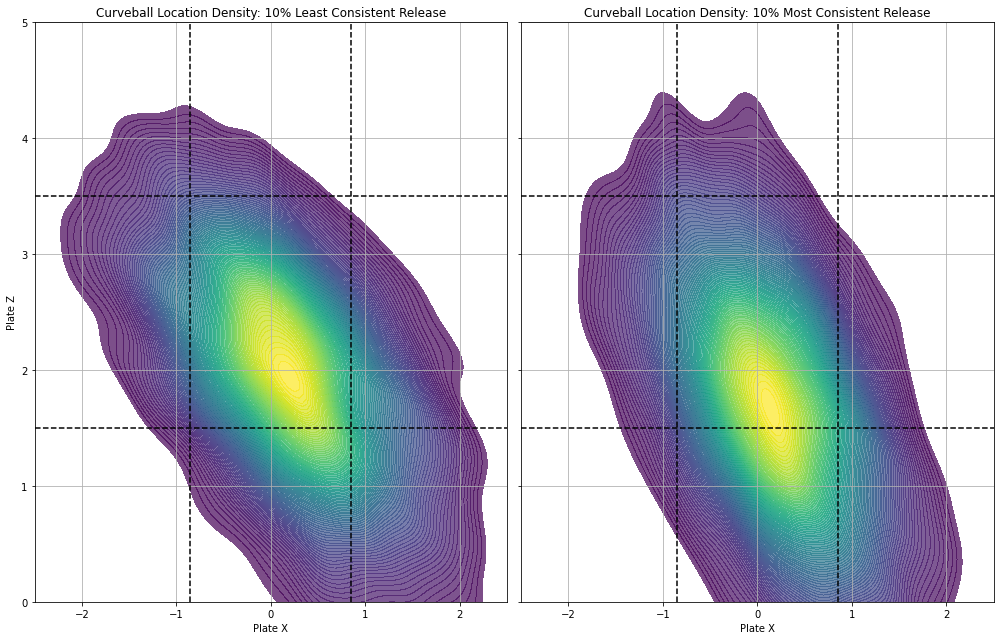

In [35]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='CU',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

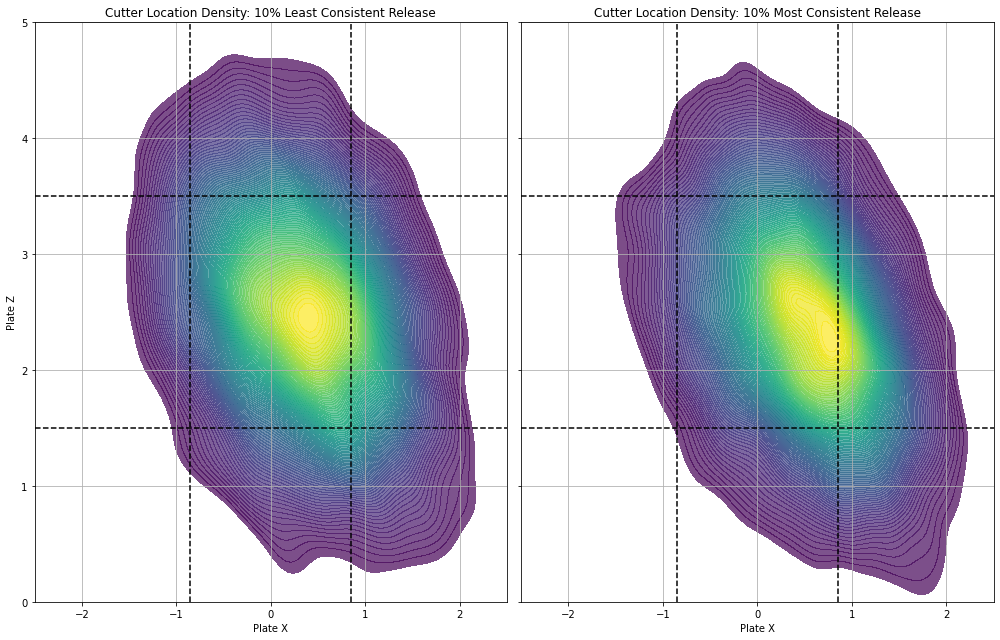

In [36]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='FC',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

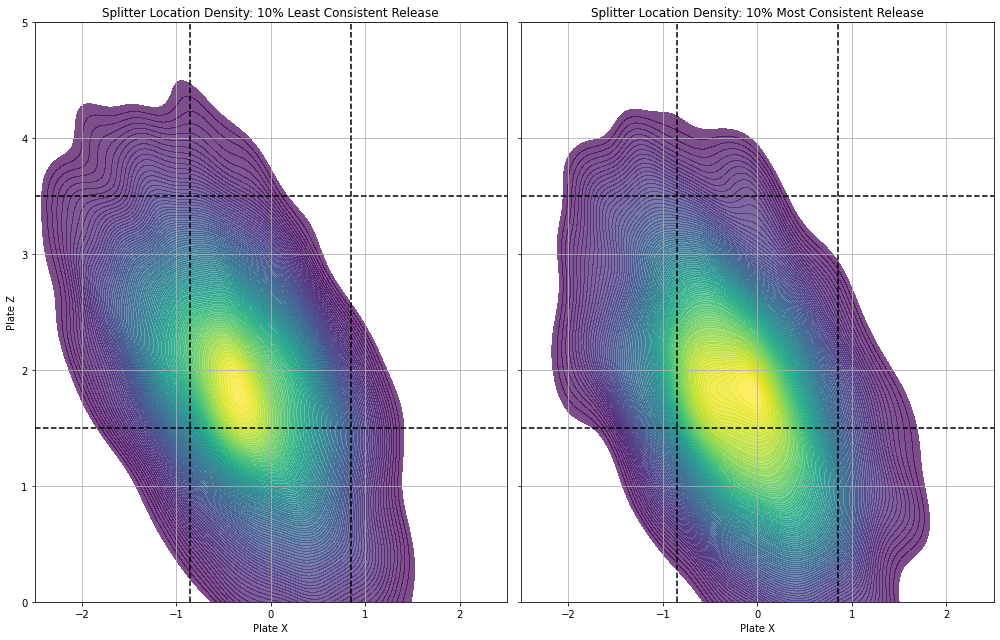

In [37]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='FS',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

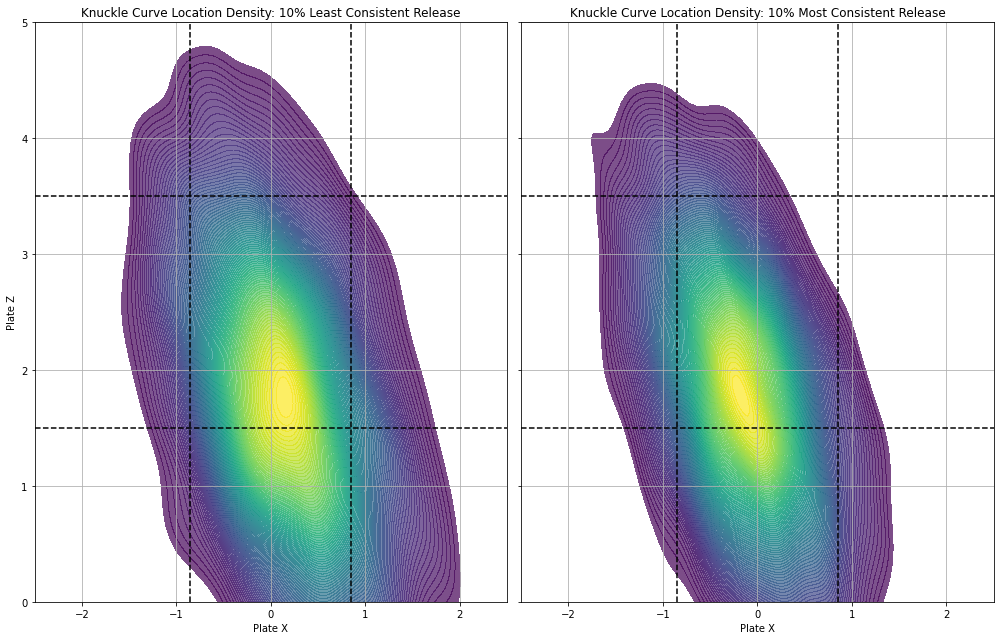

In [38]:
pitch_density_plot(
    pitches_w_stats,
    pitch_type='KC',
    percentile=0.1, 
    pitcher_hand='Mirror',
    min_pitches=400,
    weighted=False,
    bw_adjust=1
)

## Identify most and least consistent pitchers

#### Function to sort pitchers by release point deviation

In [39]:
def top_pitchers(df, min_pitches=0, top=True, top_rank='all', pitch_type='all'):
    """
    Sort pitches with the most and least release point deviation
    
    Arguments:
    df           - Pandas DataFrame aggregated to the pitcher-pitch type level
    min_pitches  - Minimum number of pitches to be included in the ranking (int)
    top          - Indicator for whether to get the most (True) or least (False) consistent release points (boolean)
    top_rank     - Number of pitches to include. 'all' will pull every eligible pitch, otherwise must be an integer (int)
    pitch_type   - Pitch type to consider, default is all pitches (string)
    
    Returns:
    Pandas DataFrame sorted by average release point deviation for the given pitch type. Includes the pitcher
    name, pitch type, average release point deviation, location scores, and number of pitches
    """
    # Filter dataframe
    if pitch_type == 'all':
        df = df[df['total_pitches']>=min_pitches]
    else:
        df = df[(df['total_pitches']>=min_pitches) & (df['pitch_type']==pitch_type)]
            
    # Retrieve player names
    player_key = pb.playerid_reverse_lookup(df['pitcher'], key_type='mlbam')
    player_key['full_name'] = player_key['name_first'] + ' ' + player_key['name_last']
    player_key['full_name'] = player_key['full_name'].str.title()
    player_key = player_key[['key_mlbam', 'full_name']]
    
    # Join player names
    df = df.merge(player_key, how='left', left_on='pitcher', right_on='key_mlbam')
    
    # Order and filter
    df = df[['full_name', 'pitch_type', 'wt_avg_release_pt_dev', 'Loc+', 'botCmd', 'total_pitches']]
    
    if top==True:
        df = df.sort_values('wt_avg_release_pt_dev')
    elif top==False:
        df = df.sort_values('wt_avg_release_pt_dev', ascending = False) 
    else:
        return("Error: Please check 'top' parameter")
    
    if top_rank != 'all':
        df = df.reset_index(drop=True).loc[0:top_rank-1,:]
        
    return df.reset_index(drop=True)

#### Rank all pitches with at least 400 thrown

In [40]:
pitch_rank = top_pitchers(pitcher_pitch_full, min_pitches = 400, top = True, top_rank='all')

#### Summary of Ranking

In [41]:
print(f"Mean Release Point Deviation: {round(np.mean(pitch_rank['wt_avg_release_pt_dev']), 3)} feet")
print(f"Median Release Point Deviation: {round(np.median(pitch_rank['wt_avg_release_pt_dev']), 3)} feet")
print(f"Number of Pitches: {len(pitch_rank)}")

Mean Release Point Deviation: 0.113 feet
Median Release Point Deviation: 0.105 feet
Number of Pitches: 1217


#### 10 pitches with the most consistent release point

In [42]:
top_pitchers(pitcher_pitch_full, min_pitches = 400, top = True, top_rank=10)

,full_name,pitch_type,wt_avg_release_pt_dev,Loc+,botCmd,total_pitches
0,Taylor Rogers,SI,0.057386,93.0,50.0,911.0
1,Chris Stratton,SL,0.060981,104.0,52.0,467.0
2,Daniel Hudson,SL,0.062424,99.0,49.0,441.0
3,Taylor Rogers,ST,0.063331,NaN,NaN,982.0
4,Evan Phillips,ST,0.065275,NaN,NaN,770.0
5,Kyle Nelson,SL,0.066526,107.0,64.0,593.0
6,Brad Hand,ST,0.066672,NaN,NaN,483.0
7,Chris Stratton,CU,0.067013,98.0,53.0,473.0
8,Scott Mcgough,FS,0.067098,92.0,50.0,674.0
9,Will Vest,SL,0.067253,100.0,42.0,511.0


#### 20 pitches with the least consistent release point

In [43]:
top_pitchers(pitcher_pitch_full, min_pitches = 400, top = False, top_rank=20)

,full_name,pitch_type,wt_avg_release_pt_dev,Loc+,botCmd,total_pitches
0,Matt Strahm,SL,0.577379,95.0,50.0,550.0
1,Chase Anderson,FF,0.513019,93.0,42.0,510.0
2,Chase Anderson,FC,0.507311,103.0,44.0,725.0
3,Matt Strahm,SI,0.500495,104.0,68.0,407.0
4,Wandy Peralta,SI,0.445049,101.0,38.0,586.0
5,Chase Anderson,CH,0.403321,111.0,62.0,641.0
6,Matt Strahm,FF,0.365719,101.0,62.0,1140.0
7,Yariel Rodríguez,SL,0.356519,101.0,55.0,424.0
8,Wandy Peralta,CH,0.346496,99.0,52.0,644.0
9,Raisel Iglesias,FF,0.288041,105.0,56.0,582.0
